## Punctate metric is biasing genes with fewer spots per cell to have more punctate scores

Same issue with radial metric

Definitely occuring when the number of spots, m = 1

Not sure actually if this is occuring when m > 1, but I'll test that now

I've added a method to the Cell class to filter out genes with counts below a threshold

In [57]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting

importlib.reload(SRRS)
importlib.reload(metrics)
importlib.reload(scoring)
importlib.reload(plotting)

sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample.num_cells

152

In [58]:
%%time
#fast
unfilt_cells = [c for c in sample.iter_cells() if c.n > 300]
unfilt_scored_cells = list(scoring._iter_scores(unfilt_cells, metric_name='radial', processes=3))

len(unfilt_scored_cells)

CPU times: user 2.03 s, sys: 82 ms, total: 2.12 s
Wall time: 2.8 s


73

In [59]:
%%time

#slow since gene_vars need to be recalculated
min_gene_spots = 2
filt_cells = [c.filter_low_count_genes(min_gene_spots) for c in sample.iter_cells() if c.n > 300]

filt_cells = scoring._iter_vars(filt_cells)    
filt_scored_cells = list(scoring._iter_scores(filt_cells, metric_name='radial', processes=3))

len(filt_scored_cells)

CPU times: user 2.61 s, sys: 141 ms, total: 2.75 s
Wall time: 1min 44s


73

In [61]:
#get median gene ranks for each cell
pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
61,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
62,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
63,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
64,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


In [5]:
#get per spot per cell ranks instead
data = {
    'filtering':[],
    'cell_id':[],
    'gene':[],
    'rank':[],
    'm':[],
    'n':[],
}

for filtering,cells in (('filt',filt_scored_cells),('unfilt',unfilt_scored_cells)):
    for cell in cells:
        for z in cell.zslices:
            for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
                data['filtering'].append(filtering)
                data['cell_id'].append(cell.cell_id)
                data['gene'].append(g)
                data['rank'].append(r)
                data['m'].append(cell.gene_counts[g])
                data['n'].append(cell.n)
            
spot_ranks = pd.DataFrame(data)
spot_ranks  

,filtering,cell_id,gene,rank,m,n
0,filt,104773525917171323315032845506736864421,Cdh12,152,12,288
1,filt,104773525917171323315032845506736864421,Rorb,214,18,288
2,filt,104773525917171323315032845506736864421,Prdm8,155,7,288
3,filt,104773525917171323315032845506736864421,Cdh12,99,12,288
4,filt,104773525917171323315032845506736864421,Lsp1,15,2,288
...,...,...,...,...,...,...
81958,unfilt,98094925393968329130254909503130262661,Marcksl1,767,26,818
81959,unfilt,98094925393968329130254909503130262661,C1ql3,158,47,818
81960,unfilt,98094925393968329130254909503130262661,Sulf2,109,37,818
81961,unfilt,98094925393968329130254909503130262661,Shisa9,405,19,818


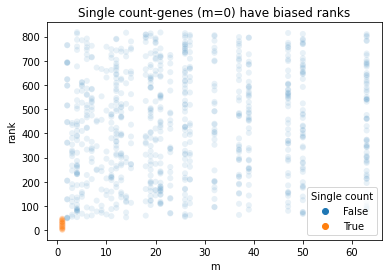

In [9]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('unfilt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Unfiltered, Single count-genes (m=0) have biased ranks')
plt.show()
plt.close()

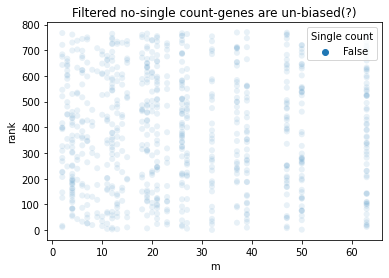

In [12]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('filt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Filtered no-single count-genes are un-biased(?)')
plt.show()
plt.close()

# Formalizing test for punctate bias by gene-count

Now that I've applied the filtering, I can visually see that the bias might be removed

But how can I quantitatively be sure?

I'm going to start by plotting punctate score vs gene/fraction from all cells and see if it "looks correct"

In [62]:
score_df = pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'),ignore_index=True)
score_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
4394,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
4395,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
4396,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
4397,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


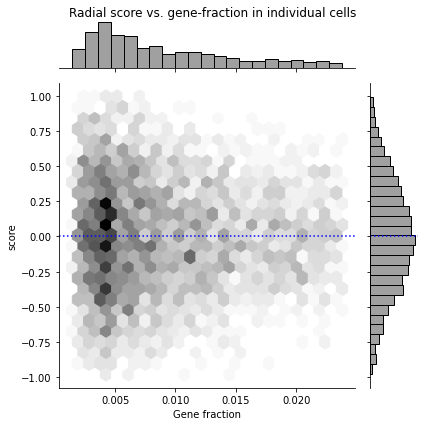

In [63]:
score_df['Gene fraction'] = score_df['num_gene_spots'].div(score_df['num_spots'])
max_frac = score_df['Gene fraction'].quantile(0.8)

p = sns.jointplot(
    x = 'Gene fraction',
    y = 'score',
    kind = 'hex',
    color = 'grey',
    data = score_df[score_df['Gene fraction'].le(max_frac)],
)

p.ax_joint.axhline(0,linestyle='dotted',color='blue')
p.ax_marg_y.axhline(0,linestyle='dotted',color='blue')

#p.ax_joint.set_xlim(0,max_frac)

p.fig.suptitle('Radial score vs. gene-fraction in individual cells')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room #got code from https://stackoverflow.com/questions/60358228/how-to-set-title-on-seaborn-jointplot

plt.show()
plt.close()

the plot does "look" correct, but maybe I can visualize in a different way by binning the gene fractions and plotting CDFs

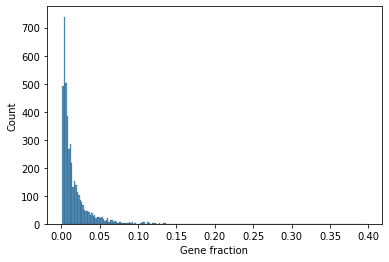

In [44]:
sns.histplot(score_df['Gene fraction'])
plt.show()
plt.close()

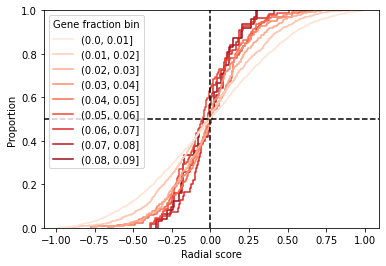

In [65]:
bins = np.arange(0,0.1,0.01)

score_df['Gene fraction bin'] = pd.cut(score_df['Gene fraction'], bins=bins)
ax = sns.ecdfplot(
    x = 'score',
    hue = 'Gene fraction bin',
    palette = 'Reds',
    data = score_df,
)
ax.axhline(0.5, linestyle='dashed', color='black')
ax.axvline(0.0, linestyle='dashed', color='black')
plt.xlabel('Radial score')
plt.show()
plt.close()

# Bootstrapping punctate metric

In [52]:
import importlib
import SRRS
from SRRS import metrics, plotting, scoring, simulate

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
sample = SRRS.HDF5('../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5')
sample

HDF5 ../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5

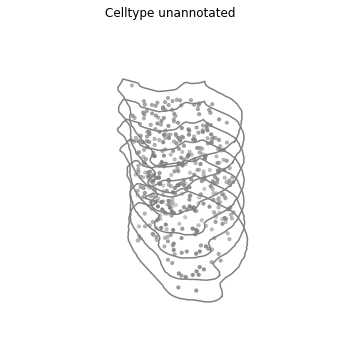

In [39]:
cell = next(sample.iter_cells())
fig,ax = plotting.plot_cell_3D(cell)
plt.show()
plt.close()

In [43]:
importlib.reload(metrics)

<module 'SRRS.metrics' from '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/src/SRRS/metrics.py'>

In [46]:
%%time
cell.ranked = False
df = metrics.punctate(cell, num_iterations=1000)
df

CPU times: user 1.14 s, sys: 3.87 ms, total: 1.14 s
Wall time: 1.14 s


,gene,rank,iteration,spot_count
0,Acta2,36,0,3
1,Adra1b,52,0,2
2,Alk,17,0,9
3,Ano4,48,0,3
4,Bcl11b,55,0,4
...,...,...,...,...
54995,Ubash3b,10,999,9
54996,Unc5d,38,999,5
54997,Vtn,2,999,7
54998,Vwc2,48,999,6


In [47]:
df.groupby('gene')['rank'].mean()

gene
Acta2         31.141
Adra1b        51.774
Alk           31.226
Ano4          41.704
Bcl11b        40.910
Camk2d        28.869
Cdh13         33.868
Cdh20         25.827
Cemip         22.701
Corin         34.626
Cspg4         14.737
Ctss           7.433
Cux2          33.758
Dscaml1       34.384
Epha7         17.147
Flt1           6.025
Grik1         29.023
Igfbp4        29.353
Iqgap2        28.839
Lhx6          31.688
Lsp1          29.532
March1        12.024
Myh14         16.403
Nhs           22.870
Nr4a1          1.002
Nxph1         13.044
Parm1         35.587
Plcxd3        43.145
Pld5          33.616
Prss12         9.179
Prss23        28.748
Ptprm         27.470
Ptprt         35.616
Rerg          27.161
Rgs5          23.331
Rnf152        23.870
Sertm1        31.365
Shisa9        35.727
Slc30a3       33.699
Slc32a1       31.133
Sox6          26.985
St6galnac5    32.442
Sulf2         27.312
Syndig1       24.322
Tbc1d4        20.155
Tcap          34.828
Thsd7a        28.515
Timp3   

In [56]:
# testing if there is bias in the "choose 2" approach by permuting gene labels
df = pd.DataFrame()

for i in range(1000):
    if i%10 == 0:
        print(i)
        
    cell = simulate.null_permute_gene_labels(cell, within_z=False)
    sub_df = metrics.punctate(cell, num_iterations=100)
    
    sub_df = sub_df.groupby(['gene','spot_count'])['rank'].mean().reset_index()
    sub_df['iteration'] = i
    df = pd.concat((df,sub_df),ignore_index=True)
    
df

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


,gene,spot_count,rank,iteration
0,Acta2,3,32.51,0
1,Adra1b,2,49.21,0
2,Alk,9,27.92,0
3,Ano4,3,29.84,0
4,Bcl11b,4,24.87,0
...,...,...,...,...
54995,Ubash3b,9,28.71,999
54996,Unc5d,5,30.47,999
54997,Vtn,7,17.88,999
54998,Vwc2,6,25.75,999


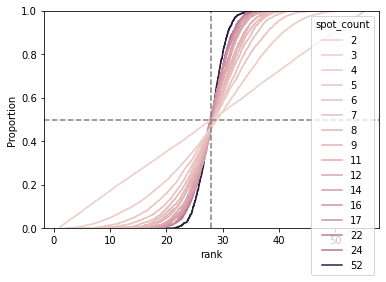

In [61]:
sns.ecdfplot(
    x = 'rank',
    hue = 'spot_count',
    data = df,
)
plt.axhline(0.5,linestyle='dashed',color='grey')
plt.axvline((len(cell.genes)+1)/2,linestyle='dashed',color='grey')
plt.show()
plt.close()

In [24]:
(cell.n+1)/2

201.5

In [29]:
spot_gene_coords = [
    (g,(x,y)) for z in cell.zslices 
    for g,(x,y) in zip(cell.spot_genes[z],cell.spot_coords[z])
]

spot_gene_coords

[('Ano4', (804.11475, -3150.0518)),
 ('Cemip', (804.16296, -3149.5718)),
 ('Slc32a1', (803.8096, -3149.246)),
 ('Slc32a1', (802.79755, -3147.5361)),
 ('Tcap', (803.9425, -3144.993)),
 ('Vtn', (803.57214, -3144.3635)),
 ('Bcl11b', (802.16016, -3143.736)),
 ('Prss23', (804.0866, -3143.7002)),
 ('Sulf2', (803.8883, -3142.6274)),
 ('Nhs', (803.9469, -3141.6313)),
 ('Parm1', (803.1893, -3141.4011)),
 ('Prss12', (803.0857, -3142.043)),
 ('Grik1', (803.7477, -3141.9766)),
 ('Epha7', (804.52844, -3146.9346)),
 ('Slc32a1', (803.87634, -3143.8074)),
 ('Lhx6', (809.3168, -3152.0493)),
 ('Rgs5', (808.6457, -3151.7415)),
 ('Grik1', (812.6797, -3149.8723)),
 ('Slc32a1', (807.0565, -3149.6528)),
 ('Unc5d', (806.2767, -3148.1501)),
 ('Slc32a1', (811.5375, -3147.665)),
 ('Prss23', (806.16565, -3144.8853)),
 ('Slc32a1', (809.6428, -3144.1465)),
 ('Rerg', (808.0472, -3144.1162)),
 ('Corin', (808.7796599999998, -3143.8103)),
 ('Slc32a1', (810.1734, -3142.08)),
 ('Slc32a1', (809.7232, -3141.4072)),
 ('Tcap

In [33]:
import random
random.shuffle(spot_gene_coords)